In [1]:
import numpy as np
import pandas as pd
from seaborn import heatmap
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

In [2]:
np.set_printoptions(suppress=True, precision=4)

%matplotlib inline

df = pd.concat([pd.read_excel(file) for file in ['2015.xlsx', '2016.xlsx', '2017.xlsx', '2018.xlsx']])

In [3]:
idx_to_remove = list(range(0,6)) + list(range(8,19)) + [20,22,23,28,31] + \
                list(range(33,38)) + list(range(38,45)) + \
                list(range(44,66)) + [30] + [68] + \
                list(range(70,82)) + [83,85] + list(range(87,113)) + \
                list(range(114,117)) + [118] + \
                list(range(120,128)) + [128] +  list(range(129,150)) + \
                list(range(152, 162))

col_to_remove = [df.columns[i] for i in idx_to_remove]

# Task 1
I am removing the vast majority of the features, 142 features to be exact. That leaves me with 20
features with which to build the model. It may seem a bit extreme but I went one by one through 
the features and removed them based on the following criteria:
- Off limits features (EPA, FE, CO2 and their derivatives)
- All feature values were NaN or a single value for all observations, these don't add information
- Feature dtype was a blob of text (a description of some sort) since this isn't easy to 
  quantitatively measure
- Anything related to car name/model/year/company since it was would also be hard to 
  convert to a quantitative measure.
- Redundant features
- Feature values were inconvenient to convert to a quantitative measure (e.g. The volume feaures). 
  My plan was to bring these in if accuracy were too low. Accuracy was good enough with given 
  features, so I never came back for these features.
    
I kept only these features:
 'Eng Displ',                 '# Cyl',
 'Air Aspir Method',          'Trans',
 '# Gears',                   'Lockup Torque Converter',
 'Trans Creeper Gear',        'Drive Sys',
 'Max Ethanol % - Gasoline',  'Fuel Usage  - Conventional Fuel',
 'Intake Valves Per Cyl',     'Exhaust Valves Per Cyl',
 'Carline Class Desc',        'Cyl Deact?',
 'Var Valve Timing?',         'Var Valve Lift?',
 'Fuel Metering Sys Cd',      'Camless Valvetrain (Y or N)',
 'Stop/Start System (Engine Management System) Code',
 '$ You Save over 5 years (amount saved in fuel costs over 5 years - on label) ',
 '$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label) ']

I one-hot encoded most features since most have categorical values. In some cases 
(e.g. Carline Class Desc) I split values into 2 dummy features to decrease the number 
of dummies. 

In [4]:
df = df.replace(to_replace={'Air Aspir Method': {np.nan: 'NA'},
                            'Max Ethanol % - Gasoline': {np.nan: 0},
                            'Drive Sys': {4: '4'},
                            'Energy Storage Device Desc': {np.nan: 'No'},
                            '$ You Save over 5 years (amount saved in fuel costs over 5 years - on label)': {np.nan: 0}
                           }) 

# split Carline Class Desc into dummy columns. One Specifies car type, the other car size
col = df['Carline Class Desc']
remove_strs = ' 4WD| 2WD|Minicompact |Subcompact |Compact |Midsize |Large ' + \
'|Small |Standard |, Cargo Types|, Passenger Type| cab chassis|Special Purpose Vehicle, '

col = col.replace(remove_strs, '', regex=True)
df = pd.concat([df, pd.get_dummies(col)], axis=1)

col = df['Carline Class Desc']
arr = []
for v in col:
    if any(s in v for s in ['Minicompact', 'Subcompact', 'Small', 'Compact', 
                            'mini', 'Two Seater']):
        arr.append('Small')
    else:
        arr.append('Large')

dummies = pd.get_dummies(pd.Series(arr, index=df.index), drop_first=True)
df = pd.concat([df, dummies], axis=1)


# Convert Money Spent, Money Saved to a single column of values and a dummy
col_save = '$ You Save over 5 years (amount saved in fuel costs over 5 years - on label) '
col_spend = '$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label) '
money_col, spend_save_dummy = [], []

for x,y in zip(df[col_save], df[col_spend]):
    if np.isnan(x):
        money_col.append(y)
        spend_save_dummy.append(1)
    else:
        money_col.append(x)
        spend_save_dummy.append(0)

df['Money'] = pd.Series(money_col, index=df.index)
df['Spent'] = pd.Series(spend_save_dummy, index=df.index)


# get dummies 
single_dummy_cols = ['Lockup Torque Converter', 'Trans Creeper Gear','Cyl Deact?', 
                     'Var Valve Lift?', 'Camless Valvetrain (Y or N)', 
                     'Stop/Start System (Engine Management System) Code',
                     'Energy Storage Device Desc', 'Var Valve Timing?']
many_dummy_cols = ['Air Aspir Method', 'Trans', 'Drive Sys', 'Fuel Metering Sys Cd', 
                   'Fuel Usage  - Conventional Fuel']

df = pd.get_dummies(df, columns=single_dummy_cols, drop_first=True)
df = pd.get_dummies(df, columns=many_dummy_cols)


# Split 2018 data from 2015-2017 and X,y values
y_all = np.array(df['Comb Unrd Adj FE - Conventional Fuel'])
y_18 = np.array(df[-1220:]['Comb Unrd Adj FE - Conventional Fuel'])
y = np.array(df[:-1220]['Comb Unrd Adj FE - Conventional Fuel'])

col_to_remove = col_to_remove + single_dummy_cols + many_dummy_cols + ['Carline Class Desc'] \
                + [col_save, col_spend]
col_keep = [c for c in df.columns if c not in col_to_remove]
df = pd.DataFrame(df, columns=col_keep)

X_all = np.array(df)
X_18 = np.array(df[-1220:])
X = np.array(df[:-1220])

### Preprocessing done!!!! Now build a simple model

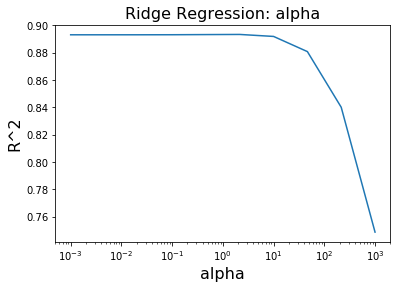

Test Set Score: 0.8902
2018 data score: 0.8757


iid Model, Test Set Score: 0.8957


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

param_grid = {'alpha': np.logspace(-3,3,10)}
reg_grid = GridSearchCV(linear_model.Ridge(), param_grid, cv=5)
reg_grid.fit(X_train, y_train)
res = pd.DataFrame(reg_grid.cv_results_)
ridge_best = reg_grid.best_estimator_

# visualize Ridge alpha
fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(res['param_alpha'], res['mean_test_score'])
ax.set_xlabel("alpha", fontsize=16)
ax.set_ylabel("R^2", fontsize=16)
ax.set_title("Ridge Regression: alpha", fontsize=16)
plt.show()

print('Test Set Score: {:.4f}'.format(ridge_best.score(X_test, y_test)))
print('2018 data score: {:.4f}'.format(ridge_best.score(X_18, y_18)))

# assume iid and re-train model
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all)
reg_grid = GridSearchCV(linear_model.Ridge(), param_grid, cv=5)
reg_grid.fit(X_train_all, y_train_all)
ridge_best = reg_grid.best_estimator_
print('\n\niid Model, Test Set Score: {:.4f}'.format(ridge_best.score(X_test_all, y_test_all)))

# TASK 2 

 -2.3315: Eng Displ
 -0.2360: # Cyl
  0.1649: # Gears
  0.0031: Max Ethanol % - Gasoline
 -0.8705: Intake Valves Per Cyl
 -1.8131: Exhaust Valves Per Cyl
  2.3599: Cars
 -0.2755: Pick-up Trucks
  0.0094: SUV
 -1.8227: Special Purpose Vehicle
  2.0849: Station Wagons
  1.2779: Two Seaters
 -3.1440: Vans
 -0.4899: minivan
  0.1964: Small
  0.0000: Money
 -2.7791: Spent
 -0.4973: Lockup Torque Converter_Y
  0.1964: Trans Creeper Gear_Y
  0.6173: Cyl Deact?_Y
  0.3841: Var Valve Lift?_Y
 -0.2940: Camless Valvetrain (Y or N)_Y
  0.9407: Stop/Start System (Engine Management System) Code_Y
 -6.6149: Energy Storage Device Desc_No
 -0.0262: Var Valve Timing?_Y
  1.3479: Air Aspir Method_NA
 -0.7746: Air Aspir Method_SC
 -0.0749: Air Aspir Method_TC
 -0.4984: Air Aspir Method_TS
 -0.6112: Trans_A
  0.2506: Trans_AM
 -1.2737: Trans_AMS
  3.4690: Trans_CVT
 -1.2580: Trans_M
 -0.5690: Trans_SA
 -0.0078: Trans_SCV
 -0.3374: Drive Sys_4
 -0.3579: Drive Sys_A
  1.2573: Drive Sys_F
 -0.5007: Drive Sys_

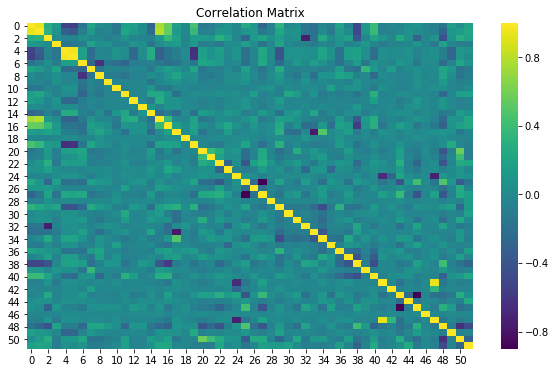

20 Highly correlated features
----------------------------------------------------------------------
-0.9008,  Air Aspir Method_NA : Air Aspir Method_TC
-0.8892,  Fuel Metering Sys Cd_GDI : Fuel Metering Sys Cd_MFI
-0.7708,  Lockup Torque Converter_Y : Trans_M
-0.7410,  # Gears : Trans_CVT
-0.7254,  Var Valve Timing?_Y : Fuel Usage  - Conventional Fuel_DU
-0.6682,  Var Valve Timing?_Y : Fuel Metering Sys Cd_CRDI
-0.6545,  Intake Valves Per Cyl : Cyl Deact?_Y
-0.6366,  Fuel Usage  - Conventional Fuel_G : Fuel Usage  - Conventional Fuel_GP
-0.6313,  Exhaust Valves Per Cyl : Cyl Deact?_Y
-0.6245,  Cars : SUV
0.4697,  Air Aspir Method_NA : Fuel Usage  - Conventional Fuel_G
0.4940,  Lockup Torque Converter_Y : Trans_SA
0.5413,  # Cyl : Spent
0.5580,  Eng Displ : Spent
0.5695,  Var Valve Lift?_Y : Fuel Usage  - Conventional Fuel_GP
0.7549,  Eng Displ : Money
0.7861,  # Cyl : Money
0.9261,  Eng Displ : # Cyl
0.9365,  Fuel Metering Sys Cd_CRDI : Fuel Usage  - Conventional Fuel_DU
0.9681,  Inta

In [6]:
# Visualize coefficients of ridge model to get some sense of their importance
# then get correlation matrix

corr = np.corrcoef(np.transpose(X_train))
for col, coef in zip(df.columns, ridge_best.coef_):
    print('{:8.4f}: {}'.format(coef, col))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
ax.set_title('Correlation Matrix')
hmap = heatmap(corr, cmap='viridis', ax=ax)
plt.show()

def get_correlated_features(X):
    vals = []
    for i in range(0, X.shape[0]):
        for j in range(0,i):
            vals.append((X[i,j],j,i))
    vals.sort()
    return vals[:10] + vals[-10:]

print("20 Highly correlated features")
print('-' * 70)
for tup in get_correlated_features(corr):
    print('{:.4f},  {} : {}'.format(tup[0], df.columns[tup[1]], df.columns[tup[2]]))

Seeing the results above, I will not remove any features at this step since it seems
that most features have significant coefficients, the only excpeptions being the kth
dummy (this is to be expected however, since I included all dummies)
and the 'money' column (also expected since I have not normalized its values and they
are in the thousands). Looking at the correlation matrix, we also see that most of the 
highly correlated features are the dummies. This is also to be expected. There are three
exceptions which I will test their removal in later tasks.

### Now scale features and tune params

In [7]:
class CustomScaler(BaseEstimator, TransformerMixin):
    ''' 
    I built this class to apply StandardScaler only on a subset of the features. Namely, those
    with continuous values. Since most features are binary, StandardScaler would 
    have have destroyed the binary relationships. Maybe there was a better way, but 
    this is the only thing I could think of. '''

    def __init__(self, cont_idxs):
        self.scalers = {}
        self.cont_col_idxs = cont_idxs

    def fit(self, X, y=None):
        if self.cont_col_idxs == None:
            self.cont_col_idxs = [0, 1, 2, 3, 15] 
        for idx in self.cont_col_idxs:
            self.scalers[idx] = StandardScaler()
            self.scalers[idx].fit(np.reshape(X[:,idx], (-1,1)))
        return self

    def transform(self, X, copy=True):
        copy = np.array(X)
        if self.scalers is not None:
            for idx in cont_col:
                copy[:,idx] = np.reshape(self.scalers[idx].transform(
                    np.reshape(X[:,idx], (-1,1))), (-1,))
            return copy
        else:
            raise Excpetion("scalers is None or cont_col_idxs is empty")

# get columns/features with continuous values in order to scale them later
all_col = list(df.columns)
cont_col = [all_col.index(col) for col in all_col 
            if set(df[col]) != set([0,1]) and set(df[col]) != set([1,2])]

# Pipeline and GridSearch with Ridge Regression
param_grid = {'model__alpha': np.logspace(-3,3,10)}
ridge_pipe = Pipeline([('scale', CustomScaler(cont_col)), ('model', linear_model.Ridge())])
reg_grid = GridSearchCV(ridge_pipe, param_grid, cv=5)
reg_grid.fit(X_train, y_train)

ridge_best = reg_grid.best_estimator_

# repeat above but now applying polynomial kernel to data
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

ridge_pipe = Pipeline([('scale', CustomScaler(cont_col)),
        ('kernel', PolynomialFeatures(2)), ('model', linear_model.Ridge())])
reg_grid = GridSearchCV(ridge_pipe, param_grid, cv=5)
reg_grid.fit(X_train, y_train)
res = pd.DataFrame(reg_grid.cv_results_)
ridge_best = reg_grid.best_estimator_

Ridge Model with scaled data
--------------------------------------------------
Pipeline(memory=None, steps=[('scale', CustomScaler(cont_idxs=None)), ('model', Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001))])

Ridge score on test set: 0.8897



Ridge Model with scaled data and polynomial kernel
--------------------------------------------------
Pipeline(memory=None,
     steps=[('scale', CustomScaler(cont_idxs=None)), ('kernel', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('model', Ridge(alpha=2.154434690031882, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Ridge score on test set: 0.9680   
Ridge score on 2018 data: 0.9494


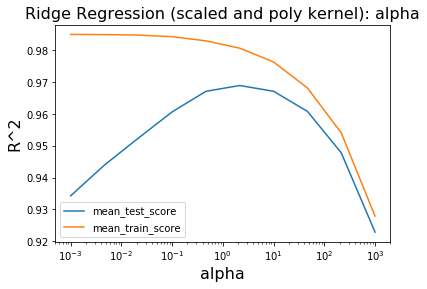

In [8]:
# visualize params of Ridge model with kernelization
fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(np.logspace(-3,3,10), res['mean_test_score'])
ax.plot(np.logspace(-3,3,10), res['mean_train_score'])
ax.set_xlabel("alpha", fontsize=16)
ax.set_ylabel("R^2", fontsize=16)
ax.legend()
ax.set_title("Ridge Regression (scaled and poly kernel): alpha", fontsize=16)
plt.show()

In [9]:
# Pipeline and GridSearch with SVR
param_grid = {'C': np.logspace(-3,3,6)}

reg_grid = GridSearchCV(SVR(), param_grid, cv=3, n_jobs=-1)
reg_grid.fit(X_train, y_train)
svr_best = reg_grid.best_estimator_

# Repeat the above, but scaling the features
param_grid = {'model__C': np.logspace(-3,3,6)}
svr_pipe = Pipeline([('scale', CustomScaler(cont_col)), ('model', SVR())])
reg_grid = GridSearchCV(svr_pipe, param_grid, cv=3, n_jobs=-1)
reg_grid.fit(X_train, y_train)
svr_best = reg_grid.best_estimator_


SVR Model without scaled features, with feature mapping
--------------------------------------------------
SVR(C=63.0957344480193, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

SVR score on test set: 0.9020


SVR Model with scaled features and feature mapping
--------------------------------------------------
Pipeline(memory=None, steps=[('scale', CustomScaler(cont_idxs=None)), ('model', SVR(C=1000.0, cache_size=200, 
        coef0=0.0, degree=3, epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, 
verbose=False))])

SVR score on test set: 0.9715
SVR score on 2018 data: 0.9551


Scaling the features has a negligible effect in the Ridge Model. The polynomial kernel 
however, does lead to a large performace increase in Ridge Model. SVR model, in turn
did increase substantially after scaling data. Currently it is the best model.

# TASK 3 

In [10]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

rand_f = RandomForestRegressor(n_estimators=100)
print('Random Forest cross val scores: \n' + '-'*50)
print(cross_val_score(rand_f, X_train, y_train, cv=5))
print('\nTest set score: {:.4f}'.format(rand_f.fit(X_train, y_train).score(X_test, y_test)))
print('2018 data score: {:.4f}'.format(rand_f.score(X_18, y_18)))

grad_boost = GradientBoostingRegressor(n_estimators=100)
print('\n\nGradient Boosting cross val scores: \n' + '-'*50)
print(cross_val_score(grad_boost, X_train, y_train, cv=5))
print('\nTest set score: {:.4f}'.format(grad_boost.fit(X_train, y_train).score(X_test, y_test)))
print('2018 data score: {:.4f}'.format(grad_boost.score(X_18, y_18)))

print('\n\nBest Model: RandomForest\n' + '-'*50)
print('iid test set score: {:.4f}'.format(rand_f.fit(X_train_all, y_train_all).score(X_test_all, y_test_all)))

Random Forest cross val scores: 
--------------------------------------------------
[0.9668 0.9643 0.9713 0.9781 0.9759]

Test set score: 0.9798
2018 data score: 0.9451


Gradient Boosting cross val scores: 
--------------------------------------------------
[0.9677 0.9602 0.969  0.9723 0.9667]

Test set score: 0.9736
2018 data score: 0.9371


Best Model: RandomForest
--------------------------------------------------
iid test set score: 0.9833


The similarity in performace of these models is somewhat expected. Their performace is on par
with the performance of the SVR model. I do not bother with scaling or kernels with these models since they are tree based and therefore robust to these methods. Random Forest seems to perfom a bit better than the rest, so this will be my model of choice

# TASK 4 
After reviewing correlation values and coefficients on the Ridge regression model in part 2,
I picked 4 features which had small (in absolute value) coefficients and/or very high (>.92)
correlation with another feature. I did not include dummy variables in this analysis for
obvious reasons.

In [11]:
remove_col = ['Exhaust Valves Per Cyl', 'Eng Displ', 'Max Ethanol % - Gasoline', 'Var Valve Timing?_Y']
idxs = [all_col.index(col) for col in remove_col]
X_sub_train = np.delete(X_train, idxs, axis=1)
X_sub_test = np.delete(X_test, idxs, axis=1)
X_sub_18 = np.delete(X_18, idxs, axis=1)

rand_f = RandomForestRegressor(n_estimators=100)
print('Random Forest (with extraneous features removed) cross val scores: \n' + '-'*50)
print(cross_val_score(rand_f, X_sub_train, y_train, cv=5))
print('2018 data score: {:.4f}'.format(rand_f.fit(X_sub_train, y_train).score(X_sub_18, y_18)))


Random Forest (with extraneous features removed) cross val scores: 
--------------------------------------------------
[0.9553 0.9504 0.9721 0.9744 0.963 ]
2018 data score: 0.9275


The removal of these features had a measurable effect on the accuracy of the model on the 2018 data set. 
Therefore, we do not benefit from removing them. The benefits of having a smaller feature space do not 
outweigh the loss in performance. The only feature that can be removed without loss to performance is 
Max Ethanol

In task 1,2 we discovered the most influential features are all dummies, namely the dummies that indicate: 
if vehicle is electric, type of transmission, what type of vehicle (SUV, truck, etc), engine type, if 
the manufacturer specifies 'money spent' vs 'money saved